# A model of Salt Identification with Keras ConvNet
Transfer learning will probably be harder with the wonky pictures of salt identification.

In [1]:
# % matplotlib inline
import datetime as dt

# Import plotting for visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
#from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import numpy as np
import os
import pandas as pd
import pydot
import random, math
import itertools
import tensorflow as tf
from keras.applications import xception
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate
from keras.layers.core import Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, load_model
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm, tqdm_notebook, tnrange
from itertools import chain
import sys
sys.path.append("/utils/DLWorkspace-Utils/keras-multiprocess-image-data-generator/tools")
import image as T
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # for the confusion matrix

import keras.backend as K
K.set_image_data_format('channels_last')

import warnings
import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## First, let's set up our optimizer so we can choose which one later on.

In [2]:
optimizer_collections = {
    "adadelta" : Adadelta(), 
    "nadam" : Nadam(), 
    "rmsprop": RMSprop(), 
    "adam": Adam(), 
    "adagrad": Adagrad(), 
    "adamax": Adamax(), 
}

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', default=8, help='Batch size', type=int)
parser.add_argument('--nb_epochs', default=30, help='Number of Epochs', type=int)
parser.add_argument('--optimizer', default='adadelta', help='Optimizer', type=str)
parser.add_argument('--split', default=None, help='Which data set to use', type=int)
parser.add_argument('--decay', default=6e-4, help='Rate decay', type=float)
parser.add_argument('--gpus', default=1, help='Number of GPU', type=int)
parser.add_argument('--drops_epochs', default=0, help='Epochs which rate drop by x10', type=float)
parser.add_argument('--lr', default=3e-3, help='Learning Rate', type=float)
parser.add_argument('--epsilon', default=1e-6, help='Optimizer Epsilon', type=float)
parser.add_argument('--rho', default=0.95, help='Optimizer Rho', type=float)

args = parser.parse_args("--optimizer adadelta".split())
#args = parser.parse_args()

print( args )
BATCH_SIZE = 8
if args.batch_size:
    BATCH_SIZE = args.batch_size

num_gpu = args.gpus
# Number of training epochs
EPOCHS = args.nb_epochs
# data to use. 
split = args.split

LR = args.lr
DECAY = args.decay
EPS = args.epsilon
RHO = args.rho

if args.optimizer.startswith("sgd"):
    optimizer = args.optimizer
    opt = SGD(lr = LR, decay=DECAY, momentum=0.9, nesterov=True)
if args.optimizer.startswith("adam"):
    optimizer = args.optimizer
    opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=EPS, decay=DECAY)
if args.optimizer.startswith("adadelta"):
    optimizer = args.optimizer
    opt = Adadelta(lr=LR, rho=RHO, epsilon=EPS, decay=DECAY)  
if args.optimizer.startswith("rmsprop"):
    optimizer = args.optimizer
    opt = RMSprop(lr=LR, rho=RHO, epsilon=EPS, decay=DECAY)
else:
    optimizer = args.optimizer
    opt = optimizer_collections[args.optimizer]

Namespace(batch_size=8, decay=0.0006, drops_epochs=0, epsilon=1e-06, gpus=1, lr=0.003, nb_epochs=30, optimizer='adadelta', rho=0.95, split=None)


### This is a tee object to help write log output.

In [3]:
class Tee(object):
    def __init__(self, name):
        self.file = open(name, "w")
        self.stdout = sys.stdout
        sys.stdout = self
    def __del__(self):
        sys.stdout = self.stdout
        self.file.close()
    def write(self, data):
        self.file.write(data)
        self.stdout.write(data)
    def flush(self):
        self.file.flush()

## Reading in the dataset
First, we locate our data at the correct directories.

In [4]:
data_dir = '/data/kaggle/competitions/tgs-salt-identification-challenge/'
cur_dir = '/work/kaggle-practice/tgs_salt_identification/'
result_dir = os.path.join(cur_dir, 'result')
train_dir = os.path.join(data_dir, 'train')
train_dir_img = os.path.join(train_dir, 'images')
train_dir_mask = os.path.join(train_dir, 'masks')
print(train_dir)
test_dir = os.path.join(data_dir, 'test')
test_dir = os.path.join(test_dir, 'images')
#sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
IMAGE_SIZE = 128 # pixel height and width of each image--actual size of the images is 101

/data/kaggle/competitions/tgs-salt-identification-challenge/train


Here's a little piece of code if we wanted to test out different lrs and decays
```python
if os.path.isdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay))) == False:
    os.mkdir(os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay)))
    
model_dir = os.path.join(result_dir, "tgs-salt_%s_batch%s_epoch%s_lr%s_decay%s" % (optimizer, batch_size, fit_epochs, lr_top, args.decay))
```

In [5]:
# Set up location of output
if os.path.isdir(os.path.join(result_dir, "8.11-tgs-salt_%s_batch%s_epoch%s" % (optimizer, BATCH_SIZE, EPOCHS))) == False:
    os.mkdir(os.path.join(result_dir, "8.11-tgs-salt_%s_batch%s_epoch%s" % (optimizer, BATCH_SIZE, EPOCHS)))
model_dir = os.path.join(result_dir, "8.11-tgs-salt_%s_batch%s_epoch%s" % (optimizer, BATCH_SIZE, EPOCHS))
if os.path.exists(os.path.join(model_dir, "training_log")) == True:
    os.remove(os.path.join(model_dir, "training_log"))
log_file = os.path.join(model_dir, "training_log")
print("8.11-tgs-salt_%s_batch%s_epoch%s" % (optimizer, BATCH_SIZE, EPOCHS))
#sys.stdout = Tee(log_file)

8.11-tgs-salt_adadelta_batch8_epoch30


### Reading in data from files.

In [6]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col="id", usecols=[0])
depths_df = pd.read_csv(os.path.join(data_dir, "depths.csv"), index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

Organize data structures.

In [7]:
MAX_DEPTH = max(train_df["z"])
MIN_DEPTH = min(train_df["z"])
print("Max: %s, Min: %s" % (MAX_DEPTH, MIN_DEPTH))
train_df["images"] = [np.array(load_img(os.path.join(train_dir_img, '%s.png' % idx), grayscale=True)) / 255 
                      for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img(os.path.join(train_dir_mask, '%s.png' % idx), grayscale=True)) / 255 
                     for idx in tqdm_notebook(train_df.index)]
train_df["depth"] = [((np.ones_like(train_df.loc[i]["images"]) * train_df.loc[i]["z"]) - MIN_DEPTH)/(MAX_DEPTH - MIN_DEPTH)
                     for i in tqdm_notebook(train_df.index)]
print(train_df["depth"][0].shape)
train_df["images_d"] = [np.dstack((train_df["images"][i], train_df["depth"][i])) for i in tqdm_notebook(train_df.index)]
print(train_df["images_d"][0].shape)
train_df.head()

Max: 959, Min: 51



(101, 101)



(101, 101, 2)


,z,images,masks,depth,images_d
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8722466960352423, 0.8722466960352423, 0.87...","[[[0.5254901960784314, 0.8722466960352423], [0..."
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8182819383259912, 0.8182819383259912, 0.81...","[[[0.3411764705882353, 0.8182819383259912], [0..."
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.4592511013215859, 0.4592511013215859, 0.45...","[[[0.5686274509803921, 0.4592511013215859], [0..."
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7444933920704846, 0.7444933920704846, 0.74...","[[[0.5411764705882353, 0.7444933920704846], [0..."
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.8215859030837004, 0.8215859030837004, 0.82...","[[[0.06666666666666667, 0.8215859030837004], [..."


### Let's check the distribution of the data.
Depth first!

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


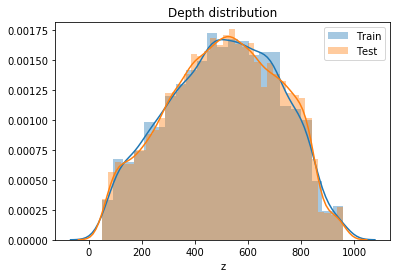

In [8]:
_ = sns.distplot(train_df.z, label="Train")
_ = sns.distplot(test_df.z, label="Test")
_ = plt.legend()
_ = plt.title("Depth distribution")

Mask coverage...
Notice that most of the pictures don't have a lot of mask coverage--the data isn't even.

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


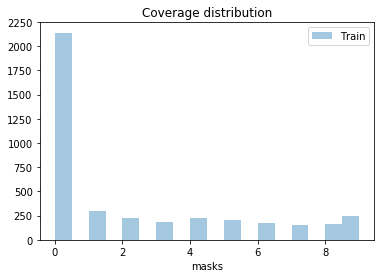

In [9]:
def coverage(mask):
    """Compute salt mask coverage"""
    return np.sum(mask) / (mask.shape[0]*mask.shape[1])

def coverage_class(mask):
    """Compute salt mask coverage class"""
    return (coverage(mask) * 100 //10).astype(np.int8)

_ = sns.distplot(train_df.masks.map(coverage_class), label="Train", kde=False)
_ = plt.legend()
_ = plt.title("Coverage distribution")

And let's visualize the training data!

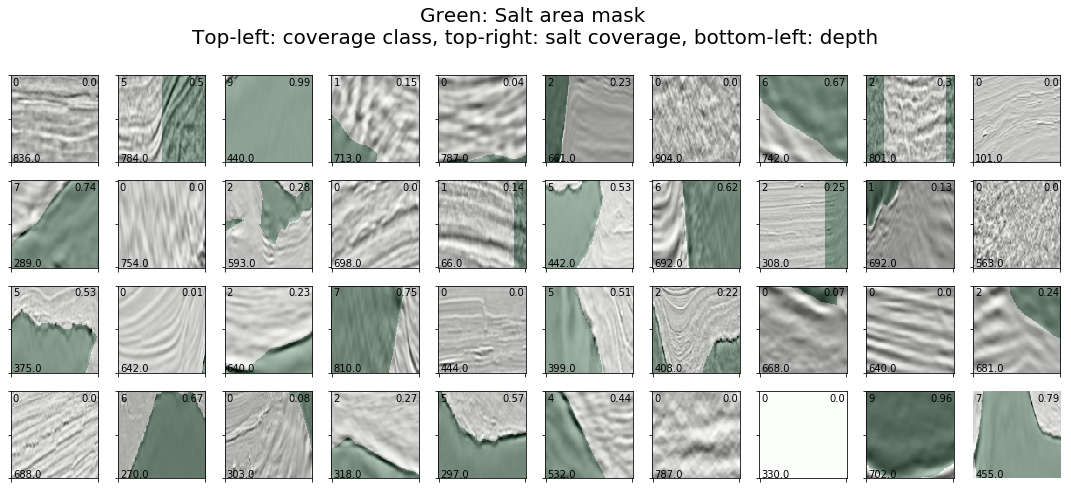

In [10]:
def plot_imgs_masks(imgs, masks, preds_valid=None, thres=None, grid_width=10, zoom=1.5):
    """Visualize seismic images with their salt area mask(green) and optionally salt area prediction(pink). 
    The prediction mask can be either in probability-mask or binary-mask form(based on threshold)
    """
    grid_height = 1 + (len(imgs)-1) // grid_width
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*zoom, grid_height*zoom))
    axes = axs.ravel()
    
    for i, img in enumerate(imgs):
        mask = masks[i]
        depth = img[0, 0, 1]
        
        
        ax = axes[i] #//grid_width, i%grid_width]
        _ = ax.imshow(img[..., 0], cmap="Greys")
        _ = ax.imshow(mask, alpha=0.3, cmap="Greens")
        
        if preds_valid is not None:
            if thres is not None:
                pred = np.array(np.round(preds_valid[i] > thres), dtype=np.float32)
            else:
                pred = preds_valid[i]
            _ = ax.imshow(pred, alpha=0.3, cmap="OrRd")
        
        _ = ax.text(2, img.shape[0]-2, depth * MAX_DEPTH//1, color="k")
        _ = ax.text(img.shape[0]-2, 2, round(coverage(mask), 2), color="k", ha="right", va="top")
        _ = ax.text(2, 2, coverage_class(mask), color="k", ha="left", va="top")
        
        _ = ax.set_yticklabels([])
        _ = ax.set_xticklabels([])
        _ = plt.axis('off')
    plt.suptitle("Green: Salt area mask \nTop-left: coverage class, top-right: salt coverage, bottom-left: depth", y=1+.5/grid_height, fontsize=20)
    plt.tight_layout();
    
# show 40 images with their masks overlaid in green
plot_imgs_masks(train_df.iloc[:40].images_d, train_df.iloc[:40].masks)

### Split the train and validation sets:

In [11]:
def upsample(img, img_size_target=IMAGE_SIZE):
    """Resize image to target"""
    img_size = img.shape[0]
    if img_size == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

def downsample(img, img_size_orig=101):
    """Resize image to original"""
    img_size = img.shape[0]
    if img_size == img_size_orig:
        return img
    return resize(img, (img_size_orig, img_size_orig), mode='constant', preserve_range=True)

In [12]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, depth_train, depth_valid = train_test_split(
    train_df.index.values,
    np.array(train_df.images_d.map(upsample).tolist()).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 2), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), 
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.masks.map(coverage_class), 
    random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(3200, 128, 128, 2)
(3200, 128, 128, 1)
(800, 128, 128, 2)
(800, 128, 128, 1)


### Image augmentation time!
According to Frank on Kaggle, shifts, zooming out, and vertical flip are not useful, so I only have zooming in and horizontal flip.

In [13]:
NB_BATCHES = 300

# The images and masks need to modified the same way, so their ImageDataGenerators are the same.
image_datagen = ImageDataGenerator(zoom_range=[.9, 1],
                                   horizontal_flip=True,)
mask_datagen = ImageDataGenerator(zoom_range=[.9, 1],
                                  horizontal_flip=True,)

# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(x_train, seed=1)
mask_datagen.fit(y_train, seed=1)

image_generator = image_datagen.flow(
    x_train,
    batch_size=BATCH_SIZE,
    seed=1)

mask_generator = mask_datagen.flow(
    y_train,
    batch_size=BATCH_SIZE,
    seed=1)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:957: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3200, 128, 128, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/usr/local/lib/python3.5/dist-packages/keras/preprocessing/image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3200, 128, 128, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [14]:
X_train_l = []
Y_train_l = []
    
# add examples to list by batch
for batch_id, (x_batch, y_batch) in tqdm_notebook(enumerate(train_generator)):
    # Add full batches only - prevent odd array shapes
    if x_batch.shape[0] == BATCH_SIZE:
        X_train_l.append(x_batch)
        Y_train_l.append(y_batch)
    # Break infinite loop manually when required number of batches is reached
    if len(X_train_l) == NB_BATCHES: break

# Sanity check all arrays are same shape
assert len(set(arr.shape for arr in X_train_l)) == 1
assert len(set(arr.shape for arr in Y_train_l)) == 1

# Stack list of arrays
X_train_augm = np.vstack(X_train_l)
Y_train_augm = np.vstack(Y_train_l)

# Sanity check stacking over first dimension
assert X_train_augm.shape[0] == BATCH_SIZE * NB_BATCHES
assert Y_train_augm.shape[0] == BATCH_SIZE * NB_BATCHES

#### Visualize the augmented data

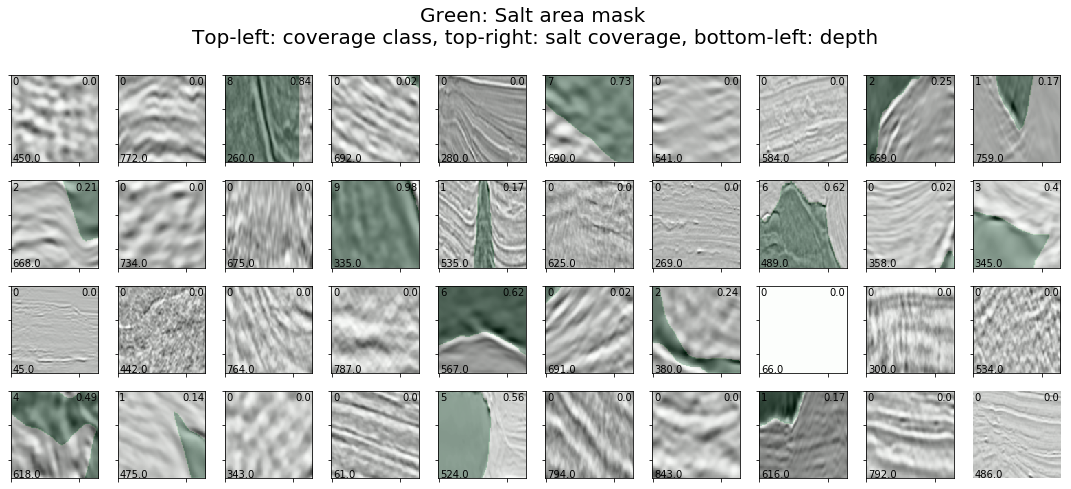

In [15]:
plot_imgs_masks(np.squeeze(X_train_augm[:40]), np.squeeze(Y_train_augm[:40]))

## Time for the actual model!
It's a mixture of a U-Net and a DenseNet.

### First, an Intersection over Union metric to calculate the accuracy of our identification.
Remember, IoU helps in object detection by figuring out the similarity (intersection/union) of two bounding boxes.

In [16]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### And now the model!
My original U-Net model before melding with DenseNet:
```python
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
```

My findings during testing:
- Optimizer? Adadelta is best.
- Dropout? Yes, it improves accuracy.
- Image size?
- Number of convblocks?
- Reduce learning rate? 

In [17]:
def dense_block(x, bn_axis, channel):
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(channel, (3, 3), padding='same', use_bias=False)(x1)
    x1 = Conv2D(channel, (3, 3), padding='same', use_bias=False)(x1)
    x = Concatenate(axis=bn_axis)([x, x1])
    x = Conv2D(channel, (3, 3), padding='same', use_bias=False)(x)
    return x

In [18]:
def up_trans_block(x, bn_axis, channel, dropout=False, dpercent=0.5):
    t = BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
    t = Activation('relu')(t)
    c = Conv2D(channel, (3, 3), activation='relu', padding='same') (t)
    p = AveragePooling2D(2, strides=2)(c)
    if dropout:
        d = Dropout(dpercent)(p)
        return d
    return p

In [19]:
def down_trans_block(x, y, bn_axis, channel, dropout=False, dpercent=0.5):
    t = BatchNormalization(axis=bn_axis, epsilon=1.001e-5)(x)
    t = Activation('relu')(t)
    c = Conv2DTranspose(channel, (2, 2), strides=(2, 2), padding='same') (t)
    u = Concatenate(axis=bn_axis)([c, y])
    if dropout:
        d = Dropout(dpercent)(u)
        return d
    return u

Draft 1 of the net:
```python
b1d0 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
b1d = Concatenate(axis=bn_axis)([b1d0, inputs])
b1t = up_trans_block(b1d, bn_axis, 16)

b2d = dense_block(b1t, bn_axis, 16)
b2t = up_trans_block(b2d, bn_axis, 32)

b3d = dense_block(b2t, bn_axis, 32)
b3t = up_trans_block(b3d, bn_axis, 64)

b4d = dense_block(b3t, bn_axis, 64)
b4t = down_trans_block(b4d, b3d, bn_axis, 32)

b5d = dense_block(b4t, bn_axis, 32)
b5t = down_trans_block(b5d, b2d, bn_axis, 16)

b6d = dense_block(b5t, bn_axis, 16)
b6t = down_trans_block(b6d, b1d, bn_axis, 8)
```

In [20]:
inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 2))

bn_axis = 3 if K.image_data_format() == 'channels_last' else 1

b1d = dense_block(inputs, bn_axis, 8)
b1t = up_trans_block(b1d, bn_axis, 8)

b2d = dense_block(b1t, bn_axis, 16)
b2t = up_trans_block(b2d, bn_axis, 16)

b3d = dense_block(b2t, bn_axis, 32)
b3t = up_trans_block(b3d, bn_axis, 32)

b4d = dense_block(b3t, bn_axis, 64)
b4t = up_trans_block(b4d, bn_axis, 64)

b5d = dense_block(b4t, bn_axis, 128)
#b5d = Conv2D(128, (3, 3), padding='same', use_bias=False)(b5d)

b6t = down_trans_block(b5d, b4d, bn_axis, 64)
b6d = dense_block(b6t, bn_axis, 64)

b7t = down_trans_block(b6d, b3d, bn_axis, 32)
b7d = dense_block(b7t, bn_axis, 32)

b8t = down_trans_block(b7d, b2d, bn_axis, 16)
b8d = dense_block(b8t, bn_axis, 16)

b9t = down_trans_block(b8d, b1d, bn_axis, 8)
b9d = dense_block(b9t, bn_axis, 8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (b9d)

In [21]:
# Create the model
saltModel = Model(inputs=[inputs], outputs=[outputs])

#### Possible Optimizers:
```python
LR = 3e-3
Adadelta(lr=LR, rho=0.95, epsilon=1e-6, decay=LR/5)  
Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay=LR/5)
SGD(lr = 0.1, decay=1e-4, momentum=0.9, nesterov=True)
SGD(lr = LR, decay=LR/5, momentum=0.9, nesterov=True)
RMSprop(lr=LR, rho=0.95, epsilon=1e-6, decay=LR/5)
```

In [22]:
# Compile the model (I'm using Adam optimizer and mean_iou accuracy for now)
saltModel.compile(optimizer=opt, loss='binary_crossentropy', metrics=[mean_iou])

In [23]:
# Let's get a summary of our model just to know what it's doing
saltModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 2)  8           input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 2)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  144         activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
# And we finally fit the model. Notice that we add an early stopper and a check pointer.
earlystopper = EarlyStopping(patience=6, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', monitor='val_loss', verbose=1, save_best_only=True)
reducelrer = ReduceLROnPlateau(patience=3, verbose=1)

DPT_SIZE = 4
print(X_train_augm.shape)
results = saltModel.fit(X_train_augm,
                    Y_train_augm, 
                    validation_data=(x_valid, y_valid),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[checkpointer])

(2400, 128, 128, 2)
Train on 2400 samples, validate on 800 samples
Epoch 1/30
2400/2400 [==============================] - 35s 15ms/step - loss: 0.4821 - mean_iou: 0.4003 - val_loss: 0.6044 - val_mean_iou: 0.4707

Epoch 00001: val_loss improved from inf to 0.60439, saving model to model-tgs-salt-1.h5
Epoch 2/30
2400/2400 [==============================] - 29s 12ms/step - loss: 0.3844 - mean_iou: 0.5045 - val_loss: 0.3559 - val_mean_iou: 0.5287

Epoch 00002: val_loss improved from 0.60439 to 0.35586, saving model to model-tgs-salt-1.h5
Epoch 3/30
2400/2400 [==============================] - 29s 12ms/step - loss: 0.3344 - mean_iou: 0.5488 - val_loss: 0.2716 - val_mean_iou: 0.5675

Epoch 00003: val_loss improved from 0.35586 to 0.27165, saving model to model-tgs-salt-1.h5
Epoch 4/30
2400/2400 [==============================] - 29s 12ms/step - loss: 0.3301 - mean_iou: 0.5785 - val_loss: 0.2863 - val_mean_iou: 0.5836

Epoch 00004: val_loss did not improve from 0.27165
Epoch 5/30
2400/2400 [

### Visualize the results.

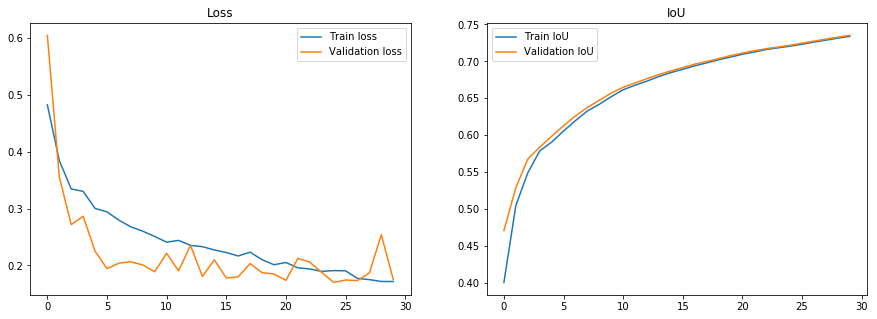

In [28]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15,5))

_ = ax_loss.plot(results.epoch, results.history["loss"], label="Train loss")
_ = ax_loss.plot(results.epoch, results.history["val_loss"], label="Validation loss")
_ = ax_loss.legend()
_ = ax_loss.set_title('Loss')
#_ = ax_acc.plot(results.epoch, results.history["acc"], label="Train accuracy")
#_ = ax_acc.plot(results.epoch, results.history["val_acc"], label="Validation accuracy")
#_ = ax_acc.legend()
#_ = ax_acc.set_title('Accuracy')
_ = ax_iou.plot(results.epoch, results.history["mean_iou"], label="Train IoU")
_ = ax_iou.plot(results.epoch, results.history["val_mean_iou"], label="Validation IoU")
_ = ax_iou.legend()
_ = ax_iou.set_title('IoU')

### Check performance on validation set.

In [30]:
saltModel = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
saltModel.evaluate(x_valid, y_valid, verbose=1)

800/800 [==============================] - 4s 5ms/step


[0.1700259664654732, 0.7604150867462158]

In [32]:
preds_valid = saltModel.predict(x_valid, 
                             verbose=1).reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

800/800 [==============================] - 2s 2ms/step


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Score the model so you can use the best IoU threshold.

In [33]:
def iou_metric(labels, y_pred, print_table=False):
    """
    src: https://www.kaggle.com/aglotero/another-iou-metric"""
    class_bins = 2

    # H : ndarray, shape(nx, ny)
    # The bi-dimensional histogram of samples x and y. 
    # Values in x are histogrammed along the first dimension and values in y are histogrammed along the second dimension.
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(class_bins, class_bins))[0] # was 0

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=class_bins)[0] # was 0 (0: no mask, 1: mask)
    area_pred = np.histogram(y_pred, bins=class_bins)[0] # was 0
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

In [34]:
def iou_metric_batch(y_true_in, y_pred_in):
    """Compute IoU batchwise"""
    batch_size = y_true_in.shape[0]
    return np.mean([iou_metric(y_true_in[b], y_pred_in[b]) for b in range(batch_size)])

In [35]:
thresholds = np.linspace(0.1, 0.9, 40)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) 
                 for threshold in tqdm_notebook(thresholds)])

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [36]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

## And now it is time to test.

### We read in the test set first.

In [37]:
x_test = [upsample(np.array(load_img(os.path.join(test_dir, '%s.png' % idx), grayscale=True))) / 255 
                   for idx in tqdm_notebook(test_df.index)]
x_test = np.array(x_test).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
print(x_test.shape)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)



(18000, 128, 128, 1)


In [44]:
# Create depth layer

x_test_d = [np.ones((128,128,1)) * ((test_df.loc[i]["z"] - MIN_DEPTH) / (MAX_DEPTH - MIN_DEPTH))
                     for i in tqdm_notebook(test_df.index)] 
print(x_test_d[0].shape)
x_test_d = np.array(x_test_d).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
print(x_test_d.shape)

(128, 128, 1)


/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


(18000, 128, 128, 1)


In [45]:
'''
train_df["depth"] = [((np.ones_like(train_df.loc[i]["images"]) * train_df.loc[i]["z"]) - MIN_DEPTH)/(MAX_DEPTH - MIN_DEPTH)
                     for i in tqdm_notebook(train_df.index)]
print(train_df["depth"][0].shape)
train_df["images_d"] = [np.dstack((train_df["images"][i], train_df["depth"][i])) for i in tqdm_notebook(train_df.index)]
'''

'\ntrain_df["depth"] = [((np.ones_like(train_df.loc[i]["images"]) * train_df.loc[i]["z"]) - MIN_DEPTH)/(MAX_DEPTH - MIN_DEPTH)\n                     for i in tqdm_notebook(train_df.index)]\nprint(train_df["depth"][0].shape)\ntrain_df["images_d"] = [np.dstack((train_df["images"][i], train_df["depth"][i])) for i in tqdm_notebook(train_df.index)]\n'

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [ ]:
# Predict on train, val and test
saltModel = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
x_test_full = [np.dstack((x_test, x_test_d)) for i in tqdm_notebook(test_df.index)]
preds_test = saltModel.predict(x_test_full)

preds_test = model.predict(x_test_full) 

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [ ]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) 
             for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

## Lastly, we prepare the submission.

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

sub.to_csv(os.path.join(model_dir, 'saltSubmission_%s_batch%s_epoch%s.csv' % (optimizer, BATCH_SIZE, EPOCHS)))

print('Prediction result saved as saltSubmission.csv')

sub.head()